### Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import sklearn.linear_model

In [5]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

### Function for adding poly features

In [7]:
def polynomial_features(feature, degree):
    """
        feature -> np.array()
        degree  -> integer
    """
    poly_df = pd.DataFrame({'power_1' : feature})
    if degree > 1:
        for power in range(2, degree+1):
            name = 'power_' + str(power)
            poly_df[name] = np.power(feature, power)
    return poly_df

In [8]:
sales = pd.read_csv('kc_house_data.csv', dtype=dtype_dict)
sales = sales.sort(['sqft_living','price'])

In [9]:
poly15_data = polynomial_features(sales['sqft_living'], 15)

In [10]:
l2_penalty = 1.5e-5
model = sklearn.linear_model.Ridge(alpha = l2_penalty, normalize = True)
model.fit(poly15_data, sales['price'])

Ridge(alpha=1.5e-05, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, solver='auto', tol=0.001)

##  Quiz Question: What’s the learned value for the coefficient of feature power_1?

In [13]:
print model.coef_

[  1.24873306e+02  -4.77376011e-02   3.01446238e-05  -2.44419942e-09
  -1.94153675e-13   8.54085686e-18   1.51142121e-21   8.27979094e-26
   6.52603100e-31  -3.27895017e-34  -3.87962315e-38  -2.72437650e-42
  -1.07790800e-46   3.78242694e-51   1.39790296e-54]


# Observe Overfitting

In [19]:
set_1 = pd.read_csv('wk3_kc_house_set_1_data.csv', dtype=dtype_dict)
set_2 = pd.read_csv('wk3_kc_house_set_2_data.csv', dtype=dtype_dict)
set_3 = pd.read_csv('wk3_kc_house_set_3_data.csv', dtype=dtype_dict)
set_4 = pd.read_csv('wk3_kc_house_set_4_data.csv', dtype=dtype_dict)

import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
def fit_15th_order_poly(feature, target, order, l2_penalty):
    poly = polynomial_features(feature, order)
    model = sklearn.linear_model.Ridge(alpha = l2_penalty, normalize = True)
    model.fit(poly, target)
    return model, poly, target

def plot_tune(model, poly, target):
    plt.plot(poly['power_1'], target, '.',
             poly['power_1'], model.predict(poly),'-')
    
def plot_tune_reduced(model, poly, target):
    plt.plot(poly['power_1'], model.predict(poly), '-')

In [27]:
ll = [fit_15th_order_poly(x['sqft_living'], x['price'], 15, 1e-9) for x in [set_1, set_2, set_3, set_4]]

[None, None, None, None]

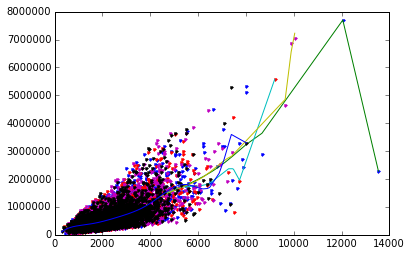

In [28]:
[plot_tune(x[0], x[1], x[2]) for x in ll]

### Quiz Question: For the models learned in each of these training sets, what are the smallest and largest values you learned for the coefficient of feature power_1?

In [30]:
[x[0].coef_[0] for x in ll]

[544.66940487941861,
 859.36266318683192,
 -755.3958208136238,
 1119.4456924088965]

## Ridge regression comes to rescue



### Fitting Ridge with large l2 penalty

In [32]:
l2_large_penalty = 1.23e2
ll = [fit_15th_order_poly(x['sqft_living'], x['price'], 15, l2_large_penalty) for x in [set_1, set_2, set_3, set_4]]

[None, None, None, None]

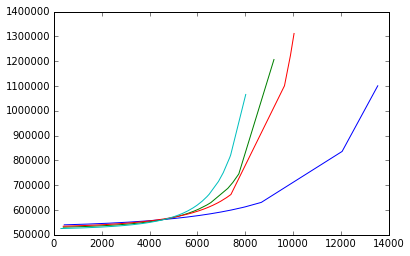

In [35]:
[plot_tune_reduced(x[0], x[1], x[2]) for x in ll]

###  QUIZ QUESTION: For the models learned with regularization in each of these training sets, what are the smallest and largest values you learned for the coefficient of feature power_1?

In [36]:
[x[0].coef_[0] for x in ll]

[2.3280680295793248, 2.0975690277785488, 2.289062581189202, 2.0859619409193062]

## Selecting an L2 penalty via cross-validation

In [37]:
train_valid_shuffled = pd.read_csv('wk3_kc_house_train_valid_shuffled.csv', dtype=dtype_dict)
test = pd.read_csv('wk3_kc_house_test_data.csv', dtype=dtype_dict)

## Implementing k-fold

In [43]:
def k_fold_ridge(data, target, nfold, l2_penalty):
    n = len(data)
    RSS_full = []
    for i in xrange(nfold):
        start = (n * i) / nfold
        end = (n * (i + 1)) / nfold - 1
        test = data[start:(end+1)]
        train = data[0:start].append(data[(end+1):n])
        model = sklearn.linear_model.Ridge(alpha=l2_penalty, normalize=True)
        model.fit(train, target[0:start].append(target[(end+1):n]))
        preds = model.predict(test)
        RSS = sum([(x - y)**2 for x,y in zip(preds,target[start:(end + 1)])])
        RSS_full.append(RSS)
    
    return np.mean(RSS)

In [39]:
l2 = np.logspace(3, 9, num=13)

In [40]:
l2

array([  1.00000000e+03,   3.16227766e+03,   1.00000000e+04,
         3.16227766e+04,   1.00000000e+05,   3.16227766e+05,
         1.00000000e+06,   3.16227766e+06,   1.00000000e+07,
         3.16227766e+07,   1.00000000e+08,   3.16227766e+08,
         1.00000000e+09])

In [41]:
poly = polynomial_features(train_valid_shuffled['sqft_living'], 15)

In [46]:
ll = [{'l2_penalty' : x, 'average_rss' : k_fold_ridge(poly, train_valid_shuffled['price'], 10, x) } for x in l2]

In [47]:
print ll

[{'l2_penalty': 1000.0, 'average_rss': 311930035765963.19}, {'l2_penalty': 3162.2776601683795, 'average_rss': 312887608807465.12}, {'l2_penalty': 10000.0, 'average_rss': 313192965569823.0}, {'l2_penalty': 31622.776601683792, 'average_rss': 313289785340337.0}, {'l2_penalty': 100000.0, 'average_rss': 313320428282162.62}, {'l2_penalty': 316227.76601683791, 'average_rss': 313330121018385.38}, {'l2_penalty': 1000000.0, 'average_rss': 313333186389520.62}, {'l2_penalty': 3162277.6601683795, 'average_rss': 313334155770871.62}, {'l2_penalty': 10000000.0, 'average_rss': 313334462318758.19}, {'l2_penalty': 31622776.601683792, 'average_rss': 313334559257970.88}, {'l2_penalty': 100000000.0, 'average_rss': 313334589912866.81}, {'l2_penalty': 316227766.01683795, 'average_rss': 313334599606798.88}, {'l2_penalty': 1000000000.0, 'average_rss': 313334602672290.06}]


### Quiz Question: What is the best value for the L2 penalty according to 10-fold validation?

In [50]:
best = reduce(lambda a,b : a if a['average_rss'] < b['average_rss'] else b, ll)
print best

{'l2_penalty': 1000.0, 'average_rss': 311930035765963.19}


### Quiz Question: Using the best L2 penalty found above, train a model using all training data. What is the RSS on the TEST data of the model you learn with this L2 penalty?

In [51]:
final_model = sklearn.linear_model.Ridge(alpha= best['l2_penalty'], normalize = True)
final_model.fit(poly, train_valid_shuffled['price'])

Ridge(alpha=1000.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, solver='auto', tol=0.001)

In [52]:
preds = final_model.predict(polynomial_features(test['sqft_living'], 15))

In [53]:
RSS = sum([(x-y)**2 for x,y in zip(preds, test['price'])])

In [54]:
print RSS

2.83856861224e+14
